In [1]:
import pandas as pd
import numpy as np

import rasterio
from skimage.transform import resize
from skimage.transform import rotate
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split

from datetime import timedelta
from skimage.draw import polygon
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

from utils import process_yield_data
from pathlib import Path

import matplotlib.pyplot as plt

#### Import Yield Data

In [2]:
YIELD_DATA_PATH = Path("./combined_yield_data.csv")
yield_data_weekly = process_yield_data(YIELD_DATA_PATH)

            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre
Date                                                                 
2012-01-02          23400.0                      23400.0          2.0
2012-01-03          26064.0                      49464.0          3.0
2012-01-04          32382.0                      81846.0          3.0
2012-01-05          69804.0                     151650.0          7.0
2012-01-06          18000.0                     169650.0          2.0

Number of Yield Data Points:  3970

Column Names: Index(['Volume (Pounds)', 'Cumulative Volumne (Pounds)', 'Pounds/Acre'], dtype='object')
Number of Yield Data Points: 2879
Yield data with time features:
            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre  \
Date                                                                    
2012-03-04         525753.0                    1785843.0    18.333333   
2012-03-11        2949534.0                    4735377.0    51.666667   
2012-03-18   

#### Define the Model

In [3]:
target_shape = (512, 512)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### Old Model

In [4]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flattened_size = self._get_conv_output((1, *target_shape))
        self.fc1 = nn.Linear(self.flattened_size, 512)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        return x
    
class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=64, lstm_layers=1):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=512, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 4, 64)
        self.fc2 = nn.Linear(64, target_shape[0] * target_shape[1])  # Predict a value per pixel
        self.target_shape = target_shape

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)  # Concatenate LSTM output with time features
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, *self.target_shape)  # Reshape to the target shape
        return x

#### Initialize Function

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# # Instantiate model with weight decay regularization
# cnn_feature_extractor = CNNFeatureExtractor()
# model = HybridModel(cnn_feature_extractor)
# model.apply(weights_init)
# model.to(device)

batch_size = 16
epochs = 50

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### Functions for prediction

In [6]:
from inference_utils import (
    preprocess_image,
    compute_mean_std,
    load_evi_data_and_prepare_features,
    find_closest_date,
    find_closest_date_in_df,
    mask_evi_data,
    predict,
    predict_weekly_yield,
    augment_image,
    prepare_dataset,
    train_and_evaluate,
    sync_evi_yield_data,
    CustomDataset,
    load_evi_data,
    find_common_date_range
)


In [7]:
# Load EVI data and prepare time features, including the dataset
evi_data_dir = "./landsat_evi_monterey_masked"
train_loader, val_loader, mean, std, dataset = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True)

Processed file 1/84 in 1.80s
Processed file 2/84 in 2.08s
Processed file 3/84 in 1.62s
Processed file 4/84 in 2.01s
Processed file 5/84 in 2.32s
Processed file 6/84 in 2.24s
Processed file 7/84 in 1.94s
Processed file 8/84 in 2.03s
Processed file 9/84 in 2.23s
Processed file 10/84 in 1.68s
Processed file 11/84 in 2.16s
Processed file 12/84 in 1.89s
Processed file 13/84 in 2.01s
Processed file 14/84 in 2.21s
Processed file 15/84 in 1.69s
Processed file 16/84 in 1.78s
Processed file 17/84 in 1.62s
Processed file 19/84 in 2.23s
Processed file 20/84 in 2.09s
Processed file 21/84 in 1.61s
Processed file 22/84 in 1.63s
Processed file 23/84 in 1.97s
Processed file 24/84 in 2.01s
Processed file 25/84 in 1.83s
Processed file 26/84 in 1.99s
Processed file 27/84 in 1.79s
Processed file 28/84 in 1.76s
Processed file 29/84 in 1.61s
Processed file 30/84 in 1.76s
Processed file 31/84 in 1.79s
Processed file 32/84 in 2.09s
Processed file 33/84 in 1.69s
Processed file 34/84 in 2.06s
Processed file 35/8

### Model Evaluation (Cross Validation)

In [8]:
# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Lists to store losses for plotting
all_train_losses = []
all_val_losses = []

epochs = 50
patience = 5 
early_stop = False

# Cross-validation with train_and_evaluate
for fold, (train_index, val_index) in enumerate(tscv.split(yield_data_weekly)):
    print(f"Fold {fold + 1}")

    # Check if indices are within bounds
    if max(train_index) >= len(dataset) or max(val_index) >= len(dataset):
        print(f"Error: Indices out of range for fold {fold + 1}")
        continue 

    # Create Subsets for the current fold
    fold_train_subset = torch.utils.data.Subset(dataset, train_index)
    fold_val_subset = torch.utils.data.Subset(dataset, val_index)

    # DataLoaders for the current fold
    fold_train_loader = DataLoader(fold_train_subset, batch_size=batch_size, shuffle=True)
    fold_val_loader = DataLoader(fold_val_subset, batch_size=batch_size, shuffle=False)

    # Instantiate a new model for each fold
    model = HybridModel(CNNFeatureExtractor())
    model.apply(weights_init)
    model.to(device)

    # Set up the optimizer, scheduler, and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.MSELoss()

    # Train and evaluate the model using the function
    val_loss, train_losses, val_losses = train_and_evaluate(
        model, fold_train_loader, fold_val_loader, optimizer, scheduler, criterion, epochs, device
    )
    
    # Store the train and val losses for visualization
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Model evaluation on the validation set
    model.eval()
    with torch.no_grad():
        outputs_val = []
        labels_val = []
        for evi_batch, label_batch, time_features_batch, timestamp in fold_val_loader:
            evi_batch, label_batch, time_features_batch = evi_batch.to(device), label_batch.to(device), time_features_batch.to(device)
            outputs_batch = model(evi_batch, time_features_batch) # lbs/pixel
            outputs_val.extend(outputs_batch.cpu().numpy().flatten())
            label_batch = label_batch.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            labels_val.extend(label_batch.cpu().numpy().flatten())

    # Flatten the outputs and labels
    outputs_val = np.array(outputs_val)
    labels_val = np.array(labels_val)

    # Calculate val metrics
    mse = mean_squared_error(labels_val, outputs_val)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_val, outputs_val)
    r2 = r2_score(labels_val, outputs_val)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1
# of samples - Training   - 111
# of samples - Validation - 106


  0%|          | 0/7 [00:00<?, ?it/s]/Users/cameron/Documents/GitHub/AgriSense-210-Capstone/train_model/inference_utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  evi_sequence = torch.tensor(evi_sequence, dtype=torch.float32).unsqueeze(1)
100%|██████████| 7/7 [00:14<00:00,  2.13s/it]


Epoch 1, Loss: 0.10986845674259323


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14601937096033776


100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Epoch 2, Loss: 0.05367119663528034


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1270972045936755


100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Epoch 3, Loss: 0.039527204419885366


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1188103479466268


100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch 4, Loss: 0.029581077130777494


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11153333980057921


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch 5, Loss: 0.02224670190896307


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10524532651262623


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Epoch 6, Loss: 0.017089979457003728


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10168895125389099


100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Epoch 7, Loss: 0.013760825486055442


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09855658068720784


100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch 8, Loss: 0.012934591488114424


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09607360565236636


100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


Epoch 9, Loss: 0.010730271360703878


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09410285710224084


100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch 10, Loss: 0.008203559688159398


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0923146295494267


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch 11, Loss: 0.005376145310167756


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0912698455420988


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Epoch 12, Loss: 0.004426109837368131


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09043576940894127


100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch 13, Loss: 0.003684635706511991


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08976020238229207


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Epoch 14, Loss: 0.003118714517248528


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08921452545161758


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Epoch 15, Loss: 0.0026136282831430435


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08875529122139726


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch 16, Loss: 0.0022172414631183657


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08838311336668474


100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


Epoch 17, Loss: 0.0019083199024732625


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08806697082971889


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Epoch 18, Loss: 0.0016439914304230893


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08780336513050965


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Epoch 19, Loss: 0.0014175046401630556


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08757774944284133


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Epoch 20, Loss: 0.0012266998611656682


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08739496897240835


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Epoch 21, Loss: 0.0011207166660044874


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08723350411414035


100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Epoch 22, Loss: 0.0009468693003457572


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08709575096145272


100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Epoch 23, Loss: 0.0008331523193711681


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08697428471142692


100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


Epoch 24, Loss: 0.0007389386550390295


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08686925460850554


100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Epoch 25, Loss: 0.0006540973388057734


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08677562500815839


100%|██████████| 7/7 [00:15<00:00,  2.23s/it]


Epoch 26, Loss: 0.0005840926730473127


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0866922875367371


100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch 27, Loss: 0.0005187014176044613


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08661983418278396


100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Epoch 28, Loss: 0.00046791234386286566


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08655762677413545


100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Epoch 29, Loss: 0.00041879655327647924


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08650345817607429


100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Epoch 30, Loss: 0.000377545045921579


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08645109657663852


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


Epoch 31, Loss: 0.00033997444552369416


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08640735862510544


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Epoch 32, Loss: 0.0003071737696050799


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08636529372805464


100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch 33, Loss: 0.00027524950149069937


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08632508791717035


100%|██████████| 7/7 [00:15<00:00,  2.20s/it]


Epoch 34, Loss: 0.0002474622243815767


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08629277381779892


100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Epoch 35, Loss: 0.00022404762109675045


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08626522175368986


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Epoch 36, Loss: 0.00020455519136573588


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08624449393911553


100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


Epoch 37, Loss: 0.00018504434306773225


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0862324382344793


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Epoch 38, Loss: 0.0001626339799258858


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08622241133291807


100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Epoch 39, Loss: 0.00014971562112415477


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0862115686593045


100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Epoch 40, Loss: 0.00013565104330025082


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08619598013215832


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Epoch 41, Loss: 0.00012068607091870425


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08618447128018099


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


Epoch 42, Loss: 0.0001039800897290531


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08616190307241466


100%|██████████| 7/7 [00:16<00:00,  2.32s/it]


Epoch 43, Loss: 9.03126570587379e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08615185537408772


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Epoch 44, Loss: 8.476739250389593e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0861448453007532


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Epoch 45, Loss: 7.531870297888028e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08613422063146052


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Epoch 46, Loss: 6.930554081918672e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08613078632125896


100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch 47, Loss: 6.660932714502061e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08612127191320594


100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Epoch 48, Loss: 5.8113314610506806e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0861134284475286


100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Epoch 49, Loss: 5.386428217337068e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08610728745614844


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch 50, Loss: 4.934076787321828e-05
Validation Loss: 0.08610119606601074


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2
# of samples - Training   - 217
# of samples - Validation - 106


100%|██████████| 14/14 [00:31<00:00,  2.24s/it]


Epoch 1, Loss: 0.10350400076380797


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.18430047375815256


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


Epoch 2, Loss: 0.046652178945285935


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15595418321234839


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


Epoch 3, Loss: 0.029942321458033154


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1416591570845672


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


Epoch 4, Loss: 0.020742558475051607


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13469565340450831


100%|██████████| 14/14 [00:29<00:00,  2.07s/it]


Epoch 5, Loss: 0.013964285608381033


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13046474674982683


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


Epoch 6, Loss: 0.009670139889099769


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12754946454827273


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


Epoch 7, Loss: 0.0068818923152451006


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12543115312499659


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 8, Loss: 0.004971779683338744


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12418405099638871


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


Epoch 9, Loss: 0.0037349365884438157


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12240107284326639


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


Epoch 10, Loss: 0.0028535155745755348


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12225969082542829


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


Epoch 11, Loss: 0.0022354432814089315


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12151270832068153


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


Epoch 12, Loss: 0.0017635102184223278


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12121028503003929


100%|██████████| 14/14 [00:30<00:00,  2.16s/it]


Epoch 13, Loss: 0.0014021015376783907


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12084055811698947


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 14, Loss: 0.001155007759475016


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12063430116644927


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


Epoch 15, Loss: 0.0009420421473415834


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1203702825919858


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 16, Loss: 0.0007774717648447092


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12014666069964212


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


Epoch 17, Loss: 0.0006579585627020736


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11995421963677343


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


Epoch 18, Loss: 0.0005292614857483256


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11980525108187326


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


Epoch 19, Loss: 0.00045052903754237505


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1196663558948785


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


Epoch 20, Loss: 0.000386421475143704


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11957689577580563


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 21, Loss: 0.0003254689062097376


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11949203736315082


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


Epoch 22, Loss: 0.0002724237212013187


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11941679199558816


100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


Epoch 23, Loss: 0.00023411170903792872


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11935806681867689


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


Epoch 24, Loss: 0.00019182924214484437


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11930686197177108


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


Epoch 25, Loss: 0.0001687204764623727


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11925207756576128


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


Epoch 26, Loss: 0.00014938281726374823


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11920789802180869


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 27, Loss: 0.00012726602965683145


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11917362550073969


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 28, Loss: 0.00010592104133268419


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11914402452072993


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 29, Loss: 8.927376932531063e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11911321385871686


100%|██████████| 14/14 [00:28<00:00,  2.00s/it]


Epoch 30, Loss: 6.138855834641228e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11906558746704832


100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


Epoch 31, Loss: 3.6894452932756394e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11904312440414547


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


Epoch 32, Loss: 2.37154272976373e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11902930668605093


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


Epoch 33, Loss: 1.75249010031361e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11902139568025762


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 34, Loss: 1.3183522826563734e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11901623199498447


100%|██████████| 14/14 [00:27<00:00,  1.97s/it]


Epoch 35, Loss: 1.0487745579926663e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11901220020653065


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 36, Loss: 8.876331873709984e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1190090182426502


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 37, Loss: 7.502723194972662e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11900668307472577


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


Epoch 38, Loss: 6.620353912824482e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1190049631425479


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Epoch 39, Loss: 5.688243748279222e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11900328456925179


100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


Epoch 40, Loss: 5.038931330351001e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11900211694176376


100%|██████████| 14/14 [00:27<00:00,  2.00s/it]


Epoch 41, Loss: 4.495933012549358e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11900127622409075


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 42, Loss: 4.156758499058404e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11900045494725678


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 43, Loss: 3.75284469100734e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899955339803066


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


Epoch 44, Loss: 3.4851096545805504e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899885657320348


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 45, Loss: 2.9559622183634408e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899823573315059


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


Epoch 46, Loss: 2.48314514042899e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899763387763025


100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


Epoch 47, Loss: 1.975359258007562e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899701569706979


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 48, Loss: 1.7755107738334378e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1189965180660043


100%|██████████| 14/14 [00:28<00:00,  2.02s/it]


Epoch 49, Loss: 1.5858350812842609e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11899591959601301


100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


Epoch 50, Loss: 1.3756204282344697e-06
Validation Loss: 0.11899554768219137


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3
# of samples - Training   - 323
# of samples - Validation - 106


100%|██████████| 21/21 [00:41<00:00,  1.99s/it]


Epoch 1, Loss: 0.057937342540494034


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16023600048252515


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 2, Loss: 0.01930335523294551


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14491277081625803


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 3, Loss: 0.009150610593635412


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13919905998877116


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 4, Loss: 0.0037496459969718543


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13462197880393692


100%|██████████| 21/21 [00:40<00:00,  1.94s/it]


Epoch 5, Loss: 0.0013039989086488883


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13366443035192788


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 6, Loss: 0.0006223015897419481


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13333348860032856


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 7, Loss: 0.00038711082570010884


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13320883037522435


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 8, Loss: 0.00023301193453205218


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13315599319425278


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 9, Loss: 0.00015451121968605244


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13312139174169196


100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Epoch 10, Loss: 0.00011757251819030248


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13310486723535828


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 11, Loss: 7.803244660040253e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13308986625634134


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 12, Loss: 6.579060417217468e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330814317001828


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 13, Loss: 4.62451135674547e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330782585178635


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 14, Loss: 3.6192566680949224e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330731748353823


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 15, Loss: 2.2499077030737508e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13306615088783605


100%|██████████| 21/21 [00:41<00:00,  1.95s/it]


Epoch 16, Loss: 1.6918170980976095e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13306210938441967


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 17, Loss: 1.3362816281144097e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13306149077003024


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 18, Loss: 1.0966067542367022e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13306111985002644


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 19, Loss: 8.23829982653565e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330598269996699


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 20, Loss: 6.320689938850895e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305851325692078


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 21, Loss: 4.234896718593345e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305677704712643


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Epoch 22, Loss: 2.8250542432791312e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330565423995722


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 23, Loss: 2.4383516331129485e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305573053990624


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Epoch 24, Loss: 2.0796461106848644e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330551642874655


100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Epoch 25, Loss: 1.87091859515931e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305478443258575


100%|██████████| 21/21 [00:42<00:00,  2.04s/it]


Epoch 26, Loss: 1.3317508968195095e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305444633338734


100%|██████████| 21/21 [00:42<00:00,  2.00s/it]


Epoch 27, Loss: 1.0964833152337677e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305410903246542


100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Epoch 28, Loss: 1.0862273007833642e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330539584658774


100%|██████████| 21/21 [00:42<00:00,  2.04s/it]


Epoch 29, Loss: 9.974733102137093e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305372944367783


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Epoch 30, Loss: 9.085807462161895e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305354789398344


100%|██████████| 21/21 [00:41<00:00,  1.99s/it]


Epoch 31, Loss: 8.560744639734843e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305345950565034


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Epoch 32, Loss: 7.100651400616612e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305336629439676


100%|██████████| 21/21 [00:40<00:00,  1.94s/it]


Epoch 33, Loss: 6.442219679619094e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305321838873038


100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Epoch 34, Loss: 5.946623822356265e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305312899007862


100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Epoch 35, Loss: 5.693408979823289e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305305498735315


100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


Epoch 36, Loss: 5.346981392254488e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305285473221115


100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Epoch 37, Loss: 4.967202688108262e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305275990361615


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 38, Loss: 4.632253234961224e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305270510941877


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 39, Loss: 4.5099607231826495e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305261570660928


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 40, Loss: 4.032176974533286e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305255578182237


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 41, Loss: 3.707821503797147e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330524507793598


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 42, Loss: 3.228639305537702e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305241383412586


100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 43, Loss: 3.092987595567008e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330523788346909


100%|██████████| 21/21 [00:41<00:00,  1.96s/it]


Epoch 44, Loss: 2.880662382917113e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305233676302514


100%|██████████| 21/21 [00:40<00:00,  1.94s/it]


Epoch 45, Loss: 2.6620986321155387e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330522740442705


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Epoch 46, Loss: 2.3799594895903977e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305223773100547


100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch 47, Loss: 2.2477059536370126e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305218773894012


100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Epoch 48, Loss: 2.0910456875017623e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1330521677404509


100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Epoch 49, Loss: 1.8765674017881144e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13305215160861344


100%|██████████| 21/21 [00:40<00:00,  1.94s/it]


Epoch 50, Loss: 1.7140793927085595e-07
Validation Loss: 0.13305212667078845


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4
# of samples - Training   - 429
# of samples - Validation - 106


100%|██████████| 27/27 [00:56<00:00,  2.08s/it]


Epoch 1, Loss: 0.06997741703633908


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17789664811321668


100%|██████████| 27/27 [01:01<00:00,  2.26s/it]


Epoch 2, Loss: 0.02020008027277611


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15889452384518726


100%|██████████| 27/27 [01:01<00:00,  2.26s/it]


Epoch 3, Loss: 0.00871593591377691


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15247997042856046


100%|██████████| 27/27 [00:58<00:00,  2.18s/it]


Epoch 4, Loss: 0.004241184409086903


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1498691878680672


100%|██████████| 27/27 [01:01<00:00,  2.27s/it]


Epoch 5, Loss: 0.002312230196333042


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14887670198056316


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


Epoch 6, Loss: 0.0013719062338134757


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14815497541401004


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


Epoch 7, Loss: 0.0008587352920720285


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1477117878883811


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 8, Loss: 0.000593322814286997


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1474410940427333


100%|██████████| 27/27 [01:00<00:00,  2.22s/it]


Epoch 9, Loss: 0.00038052341605415913


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14730255403888545


100%|██████████| 27/27 [01:00<00:00,  2.22s/it]


Epoch 10, Loss: 0.0002654022838989342


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14721735497005284


100%|██████████| 27/27 [01:01<00:00,  2.27s/it]


Epoch 11, Loss: 0.00018843233556253836


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14714442037802655


100%|██████████| 27/27 [01:01<00:00,  2.30s/it]


Epoch 12, Loss: 0.00013180122159947469


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14709786121550547


100%|██████████| 27/27 [01:00<00:00,  2.24s/it]


Epoch 13, Loss: 8.281141627877433e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470485953302289


100%|██████████| 27/27 [01:01<00:00,  2.29s/it]


Epoch 14, Loss: 2.757617497721825e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703014688815788


100%|██████████| 27/27 [01:01<00:00,  2.27s/it]


Epoch 15, Loss: 1.4576073277162828e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702502107164556


100%|██████████| 27/27 [01:00<00:00,  2.26s/it]


Epoch 16, Loss: 9.273065399139779e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702362562197127


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


Epoch 17, Loss: 6.876818866253921e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702283122772183


100%|██████████| 27/27 [01:03<00:00,  2.34s/it]


Epoch 18, Loss: 5.472335908928437e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470223186999127


100%|██████████| 27/27 [01:02<00:00,  2.30s/it]


Epoch 19, Loss: 4.416826085515721e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702228564315842


100%|██████████| 27/27 [01:03<00:00,  2.35s/it]


Epoch 20, Loss: 3.356411849819307e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702247072584992


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Epoch 21, Loss: 2.4331968183509566e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470221509163301


100%|██████████| 27/27 [01:01<00:00,  2.28s/it]


Epoch 22, Loss: 2.0785846151772638e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702203103141592


100%|██████████| 27/27 [01:01<00:00,  2.28s/it]


Epoch 23, Loss: 1.6959043465350178e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702194944194552


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


Epoch 24, Loss: 1.4891933675345272e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702182799477928


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


Epoch 25, Loss: 1.3206323880391817e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702174686161534


100%|██████████| 27/27 [01:00<00:00,  2.24s/it]


Epoch 26, Loss: 1.1359828093831041e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702175228532205


100%|██████████| 27/27 [01:02<00:00,  2.31s/it]


Epoch 27, Loss: 7.917937081300705e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470216363585288


100%|██████████| 27/27 [01:03<00:00,  2.33s/it]


Epoch 28, Loss: 7.431089199127639e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702156820463383


100%|██████████| 27/27 [01:02<00:00,  2.30s/it]


Epoch 29, Loss: 6.752529360356776e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470214588480303


100%|██████████| 27/27 [01:02<00:00,  2.31s/it]


Epoch 30, Loss: 6.268727685420783e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702137276929403


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


Epoch 31, Loss: 5.905960765378243e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702126521920686


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 32, Loss: 5.278062149971918e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702121859175218


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Epoch 33, Loss: 4.898132233308759e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702111585730954


100%|██████████| 27/27 [00:59<00:00,  2.22s/it]


Epoch 34, Loss: 4.5528824654394596e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702105837724438


100%|██████████| 27/27 [01:00<00:00,  2.22s/it]


Epoch 35, Loss: 4.2283154597397595e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702096111847954


100%|██████████| 27/27 [00:59<00:00,  2.20s/it]


Epoch 36, Loss: 3.8651867313361707e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470208668241477


100%|██████████| 27/27 [01:00<00:00,  2.22s/it]


Epoch 37, Loss: 3.4618161045593164e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702081843487186


100%|██████████| 27/27 [01:00<00:00,  2.24s/it]


Epoch 38, Loss: 3.145919551857164e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702073254323164


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Epoch 39, Loss: 2.7971056647823353e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702066740989853


100%|██████████| 27/27 [01:00<00:00,  2.24s/it]


Epoch 40, Loss: 2.4582883771405183e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702061056076282


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 41, Loss: 2.145410320508745e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702056665555574


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 42, Loss: 1.8645346244738903e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702052053429984


100%|██████████| 27/27 [01:01<00:00,  2.26s/it]


Epoch 43, Loss: 1.5909812687040255e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702050555518195


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 44, Loss: 1.3712489487926614e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.147020480066463


100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


Epoch 45, Loss: 1.142408044706321e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470204753194204


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Epoch 46, Loss: 9.515711267508946e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702046249918307


100%|██████████| 27/27 [00:59<00:00,  2.22s/it]


Epoch 47, Loss: 7.895529366111178e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702045168607064


100%|██████████| 27/27 [01:00<00:00,  2.26s/it]


Epoch 48, Loss: 6.489593178887137e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702044995751098


100%|██████████| 27/27 [01:04<00:00,  2.37s/it]


Epoch 49, Loss: 5.3053798523108154e-08


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702044826117344


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Epoch 50, Loss: 4.3266836171453716e-08
Validation Loss: 0.14702046934481977


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5
Error: Indices out of range for fold 5
Average MSE: 0.12111885845661163
Average RMSE: 0.34627723693847656
Average MAE: 0.2495909333229065
Average R-squared: -1.0761689609393899


In [ ]:
# Re-Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

### Plot Loss Across Folds

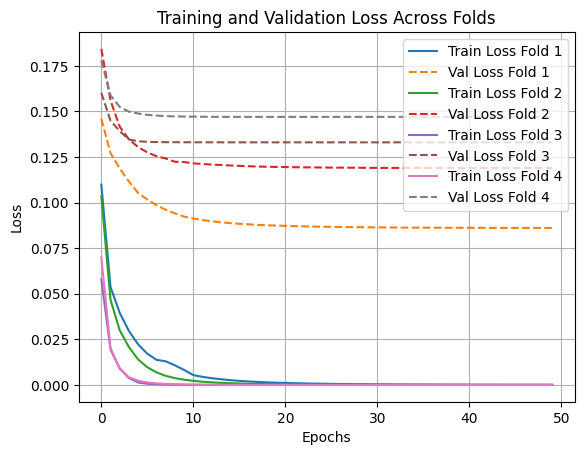

In [9]:
for fold, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
    plt.plot(train_losses, label=f'Train Loss Fold {fold + 1}')
    plt.plot(val_losses, label=f'Val Loss Fold {fold + 1}', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Train on full dataset

In [13]:
# Instantiate a new model for each fold
model = HybridModel(CNNFeatureExtractor())
model.apply(weights_init)
model.to(device)

# Set up the optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

# Train and evaluate the model
val_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device)

torch.save(model.state_dict(), "./trained-full-dataset-yield-density-no-leakage.pt")


# of samples - Training   - 439
# of samples - Validation - 110


100%|██████████| 110/110 [00:51<00:00,  2.13it/s]


Epoch 1, Loss: 0.023320678462782365


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09345273204962723


100%|██████████| 110/110 [00:51<00:00,  2.15it/s]


Epoch 2, Loss: 0.0009655885435429148


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09172485741925941


100%|██████████| 110/110 [00:51<00:00,  2.14it/s]


Epoch 3, Loss: 0.00019785482062698894


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09151628199664888


100%|██████████| 110/110 [00:51<00:00,  2.15it/s]


Epoch 4, Loss: 5.922547478059476e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09146736765881412


100%|██████████| 110/110 [00:52<00:00,  2.10it/s]


Epoch 5, Loss: 1.7829422582012326e-05


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09144632550066945


100%|██████████| 110/110 [00:57<00:00,  1.91it/s]


Epoch 6, Loss: 5.18875197909355e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09144075115729931


100%|██████████| 110/110 [00:55<00:00,  1.97it/s]


Epoch 7, Loss: 1.5495875699529776e-06


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0914394832197516


100%|██████████| 110/110 [00:51<00:00,  2.15it/s]


Epoch 8, Loss: 5.985859226146059e-07


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09143898458109893


 73%|███████▎  | 80/110 [00:37<00:14,  2.09it/s]

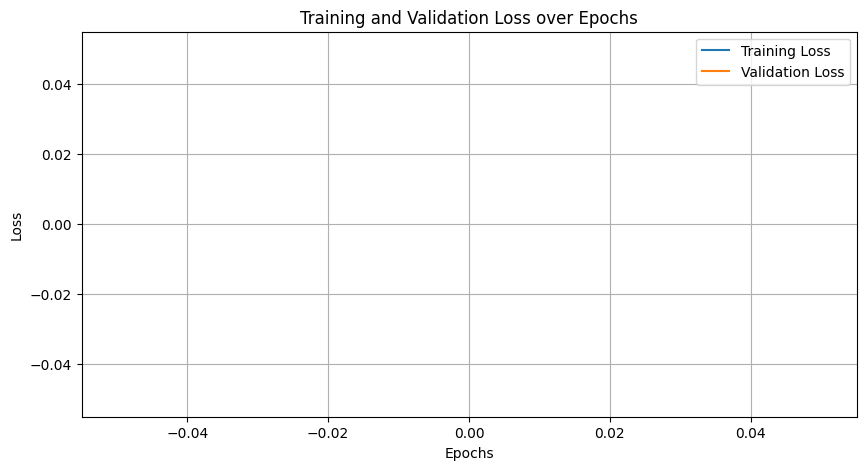

ValueError: min() arg is an empty sequence

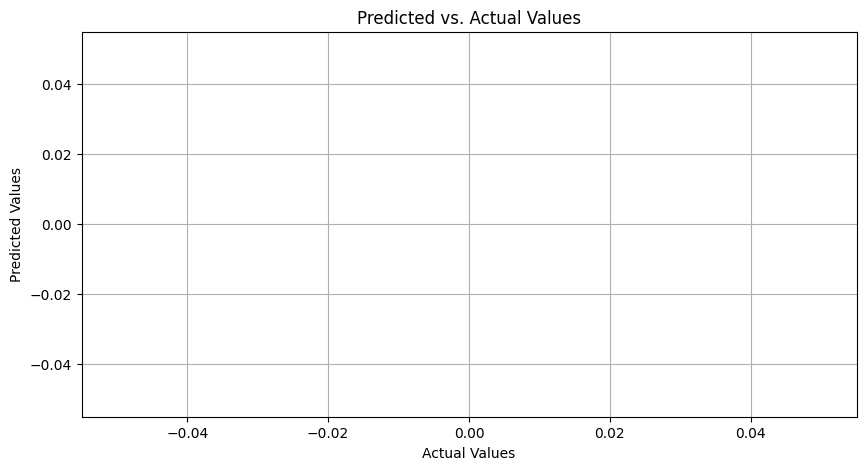

In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()g

# Inference

In [ ]:
import joblib

# load in model from file
# inf_model_weights = torch.load("trained-full-dataset.pt", weights_only=True)
inf_model_weights = torch.load("trained-full-dataset-yield-density-no-leakage.pt", weights_only=True)
inf_model = HybridModel(CNNFeatureExtractor())
inf_model.load_state_dict(inf_model_weights)
inf_model.to(device)
inf_model.eval()

scaler = joblib.load("yield_scaler.save")

In [ ]:

# inf_output = inf_model(evi_val, time_features_val)

# print(f"{evi_val.shape = }")
# print(f"{time_features_val.shape = }")
# print(f"{inf_output.shape = }")

In [ ]:
yield_data_weekly.iloc[0].name

Timestamp('2012-03-04 00:00:00')

In [ ]:

evi_data_dir = "./landsat_evi_monterey_masked"
dataset_loader, _, mean, std = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True, full=True)

Processed file 1/83 in 4.125449s
Processed file 2/83 in 4.246559s
Processed file 3/83 in 4.898093s
Processed file 4/83 in 4.672359s
Processed file 5/83 in 5.460909s
Processed file 6/83 in 4.038937s
Processed file 7/83 in 3.490030s
Processed file 8/83 in 4.127463s
Processed file 9/83 in 3.800272s
Processed file 10/83 in 3.523895s
Processed file 11/83 in 3.932964s
Processed file 12/83 in 3.734574s
Processed file 13/83 in 4.148887s
Processed file 14/83 in 4.548136s
Processed file 15/83 in 3.748950s
Processed file 16/83 in 3.109021s
Processed file 17/83 in 4.015578s
Processed file 18/83 in 4.144617s
Processed file 19/83 in 3.917441s
Processed file 20/83 in 4.372727s
Processed file 21/83 in 4.537723s
Processed file 22/83 in 3.373776s
Processed file 23/83 in 3.701019s
Processed file 24/83 in 3.277262s
Processed file 25/83 in 3.982489s
Processed file 26/83 in 4.063423s
Processed file 27/83 in 3.969857s
Processed file 28/83 in 3.823087s
Processed file 29/83 in 4.417579s
Processed file 30/83 in

In [ ]:
timestamps = torch.Tensor()
yield_labels = torch.Tensor()
predictions = torch.Tensor()

for idx, (inputs, labels, time_features, timestamp) in enumerate(dataset_loader):
    print(f"Running inference... {idx/len(dataset_loader)*100:.2f}%", end='\r')
    inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
    outputs = inf_model(inputs, time_features)
    summed_outputs = outputs.sum(dim=(1,2))

    if idx >0:
        break
    timestamps = torch.cat((timestamps, timestamp))
    yield_labels = torch.cat((yield_labels, labels.to("cpu")))
    predictions = torch.cat((predictions, summed_outputs.to("cpu")))

    # loss = criterion(outputs, labels)
    # val_loss += loss.item()

# val_loss /= len(val_loader)
# print(f'Validation Loss: {val_loss}')

In [ ]:
yield_labels.reshape(-1,1)

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
scaler.inverse_transform(yield_labels.reshape(-1, 1))

array([[20429036.3072927 ],
       [39287413.27969694],
       [22990931.39602876],
       [       0.        ]])

In [ ]:
scaler.inverse_transform(predictions.detach().numpy().reshape(-1,1))

array([[1023663.94],
       [1020795.2 ],
       [1033442.56],
       [ 977205.5 ]], dtype=float32)

In [ ]:
yield_labels

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
yield_data_weekly

,Volume (Pounds),Cumulative Volumne (Pounds),Pounds/Acre,month_sin,month_cos,day_of_year_sin,day_of_year_cos
Date,,,,,,,
2012-03-04,0.011286,1785843.0,18.333333,1.000000e+00,6.123234e-17,0.891981,0.452072
2012-03-11,0.063317,4735377.0,51.666667,1.000000e+00,6.123234e-17,0.939856,0.341571
2012-03-18,0.102446,9507645.0,83.500000,1.000000e+00,6.123234e-17,0.974100,0.226116
2012-03-25,0.067456,12649959.0,55.000000,1.000000e+00,6.123234e-17,0.994218,0.107381
2012-04-01,0.134627,18921357.0,93.857143,8.660254e-01,-5.000000e-01,0.999917,-0.012910
...,...,...,...,...,...,...,...
2024-05-12,0.767907,682790517.0,305.285714,5.000000e-01,-8.660254e-01,0.752667,-0.658402
2024-05-19,0.787426,682790517.0,365.166667,5.000000e-01,-8.660254e-01,0.668064,-0.744104
2024-05-26,0.827681,682790517.0,329.285714,5.000000e-01,-8.660254e-01,0.573772,-0.819015


In [ ]:
timestamps, yield_labels, predictions

In [ ]:
yield_data_weekly

In [ ]:
out_df = pd.DataFrame(data={"timestamp":timestamps.to_numpy(), "prediction":predictions.to_numpy(), "truth":yield_labels.to_numpy()})
out_df.to_csv("out.csv")